# Mapeamento de Tom Local (LTM) utilizando filtro bilateral
## Curso de Fotografia Computacional

### Aquisição das imagens

In [ ]:
!git clone https://github.com/kevinruiz182/iqa_img_storage.git

Cloning into 'iqa_img_storage'...
remote: Enumerating objects: 506, done.
remote: Counting objects: 100% (506/506), done.
remote: Compressing objects: 100% (411/411), done.
remote: Total 506 (delta 96), reused 500 (delta 93), pack-reused 0
Receiving objects: 100% (506/506), 32.37 MiB | 30.25 MiB/s, done.
Resolving deltas: 100% (96/96), done.


### Imports

In [ ]:
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os

In [ ]:
def open_rgb_img(img_src):
  im_cv = cv2.imread(img_src, cv2.IMREAD_UNCHANGED)
  return cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB)

def show_image(img, figsize=(30, 15)):
  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(1, 1, 1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(img, cmap="gray")
  plt.show()

def show_images(img_list, figsize=None):
  n = len(img_list)
  if figsize == None:
    figsize = (5 * n, 8)
  fig, ax = plt.subplots(1, n, figsize=figsize)
  for i in range(n):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(img_list[i], cmap="gray")
  plt.show()

### Carregando imagens

In [ ]:
high_img = open_rgb_img('iqa_img_storage/iqa/distortions/hdr/high_exposed/94.jpeg')
normal_img = open_rgb_img('iqa_img_storage/iqa/distortions/hdr/normal.jpeg')
low_img = open_rgb_img('iqa_img_storage/iqa/distortions/hdr/low_exposed/4049.jpeg')

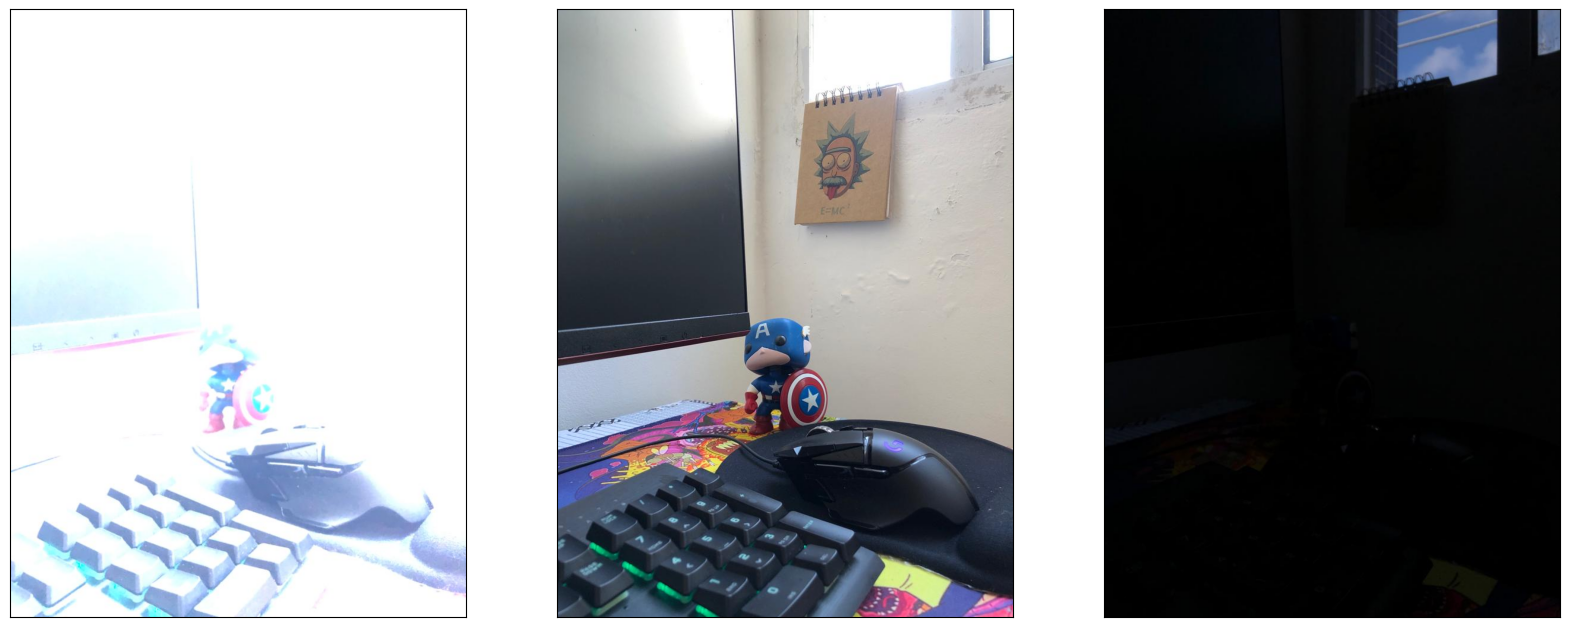

In [ ]:
show_images([high_img, normal_img, low_img], (20, 10))

### Obtendo HDR

In [ ]:
high_folder = 'iqa_img_storage/iqa/distortions/hdr/high_exposed'
low_folder = 'iqa_img_storage/iqa/distortions/hdr/low_exposed'
high_files = list([os.path.join(high_folder, f) for f in os.listdir(high_folder)])
low_files = list([os.path.join(low_folder, f) for f in os.listdir(low_folder)])
all_files = sorted(low_files + high_files)
hdr_images = list([open_rgb_img(f) for f in all_files])
exposures = np.float32([1. / t for t in [132, 258, 94, 1033, 2024, 4049]])
calibration = cv2.createCalibrateDebevec()
response = calibration.process(hdr_images, exposures)

In [ ]:
merge = cv2.createMergeDebevec()
hdr = merge.process(hdr_images, exposures, response)

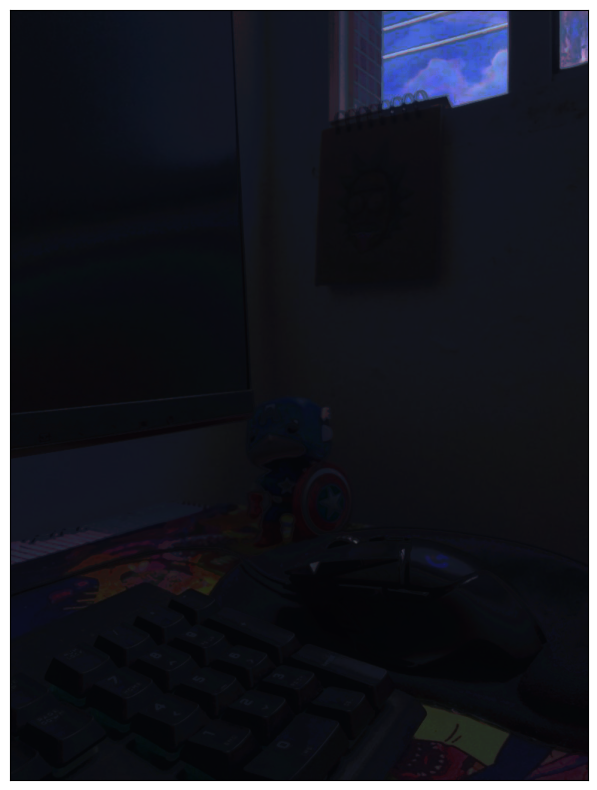

In [ ]:
show_image(hdr / hdr.max(), (10, 10))

### O que acontece se tentamos utilizar apenas compressão gama?

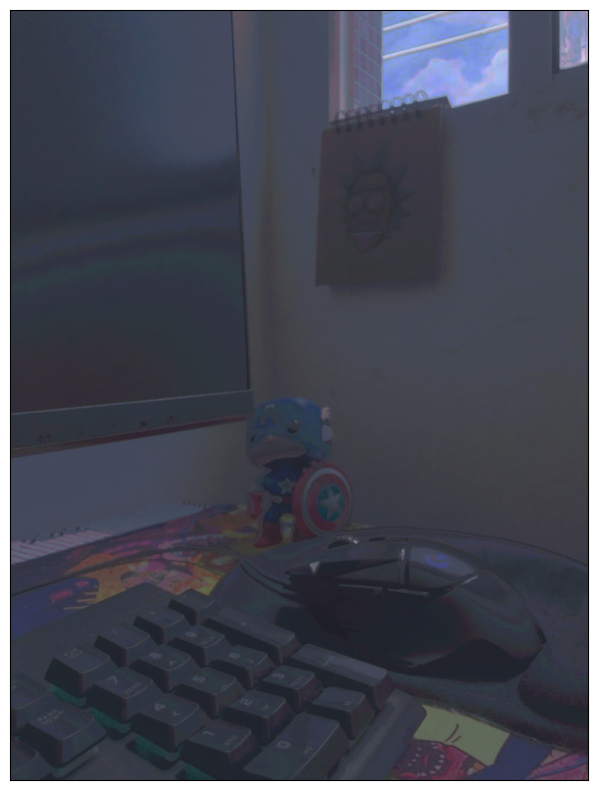

In [ ]:
show_image((hdr / hdr.max())**0.5, (10, 10))

### Rodando operador customizado

In [ ]:
def countTonemap(hdr, min_fraction=0.0005):
  counts, ranges = np.histogram(hdr, 256)
  min_count = min_fraction * hdr.size
  delta_range = ranges[1] - ranges[0]

  image = hdr.copy()
  for i in range(len(counts)):
      if counts[i] < min_count:
          image[image >= ranges[i + 1]] -= delta_range
          ranges -= delta_range

  return cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX)
custom_op = countTonemap(hdr)

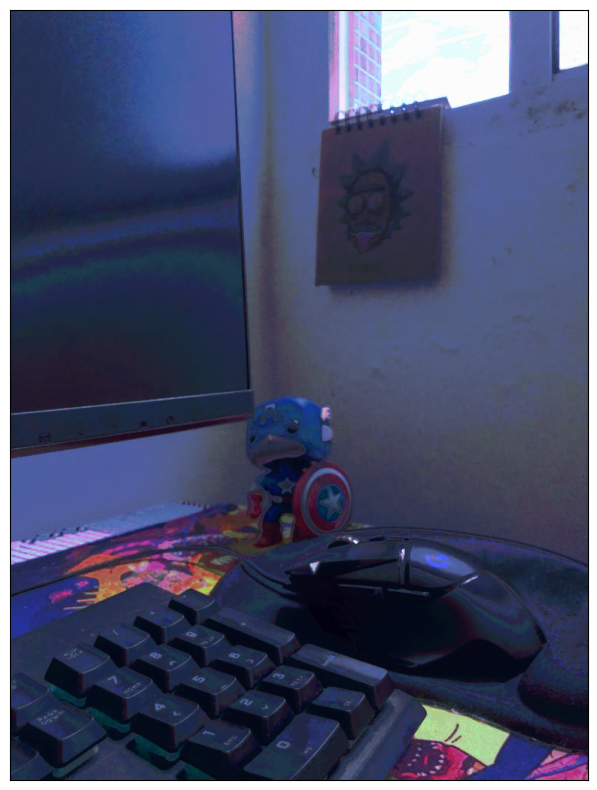

In [ ]:
show_image(custom_op, (10, 10))

### Executando o LTM


Primeiro, calculamos o canal de intensidade

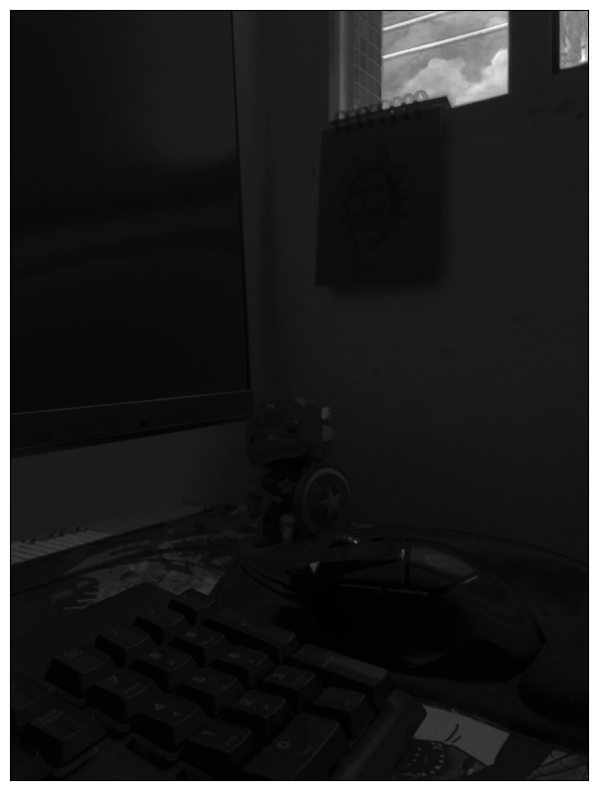

In [ ]:
r, g, b = cv2.split(hdr / hdr.max())
intensity = cv2.cvtColor(cv2.merge([r, g, b]), cv2.COLOR_RGB2GRAY) + 1e-6
show_image(intensity, (10, 10))

Obtemos o log da intensidade

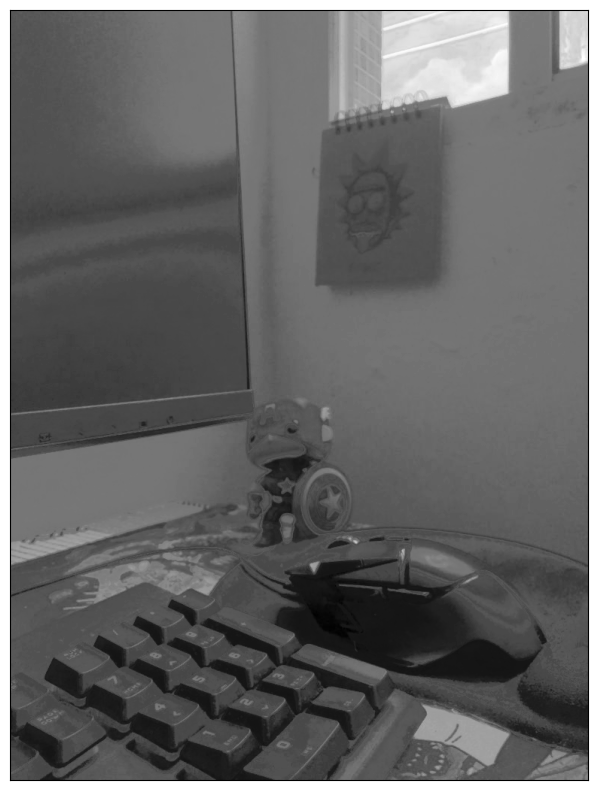

In [ ]:
log_intensity = np.log2(intensity)
show_image(log_intensity, (10, 10))

Aplicamos o filtro bilateral ao log da intensidade para obter a intensidade base ("large scale"). Os parâmetros do kernel são decididos baseados nas dimensões e valores presentes na entrada. O tamanho de kernel é escolhido como 15

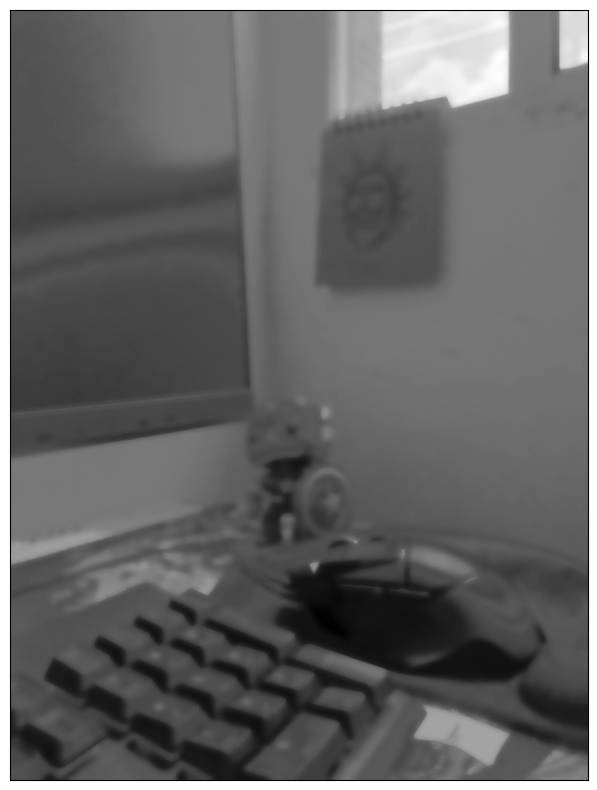

In [ ]:
# kernel espacial -> sigma relacionado ao tamanho da imagem
sigma_s = 0.02 * min(hdr.shape[:2])
# kernel intensidade -> sigma relacionado ao range de (log-)intensidades
sigma_c = 0.2 * (log_intensity.max() - log_intensity.min())
large_scale = cv2.bilateralFilter(log_intensity, 15, sigma_c, sigma_s)
show_image(large_scale, (10, 10))

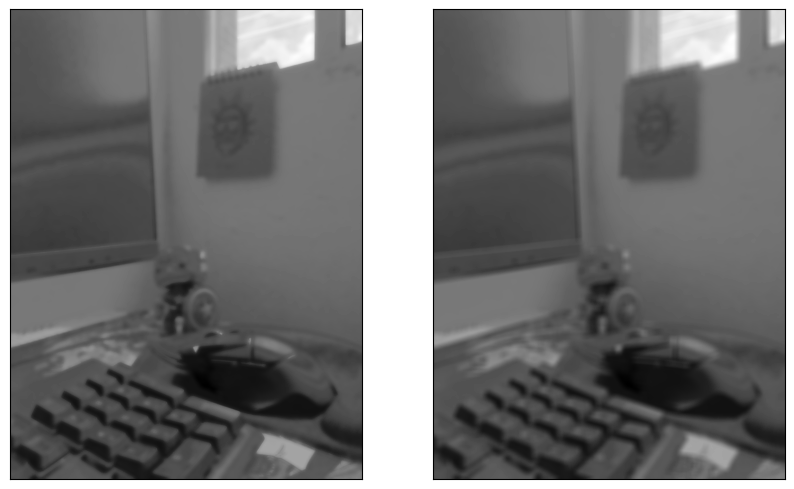

In [ ]:
show_images([large_scale, cv2.GaussianBlur(log_intensity, (15, 15), sigma_s)], (10, 10))

Subtraímos a intensidade base do log da intensida para obter características de alta frequência ("detail")

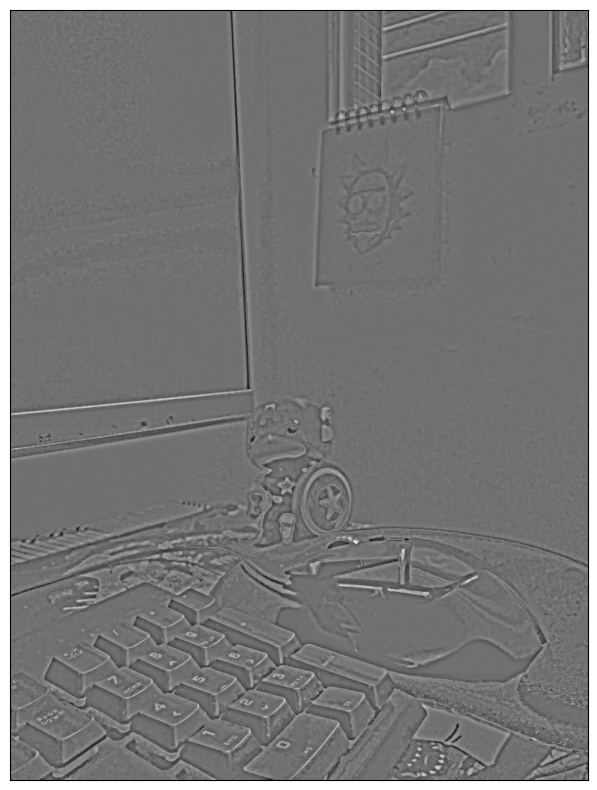

In [ ]:
detail = log_intensity - large_scale
show_image(detail, (10, 10))

Offset e escala da intensidade para obter a base final

In [ ]:
o = large_scale.max()
dR = 2 # normalmente entre 2 e 8; 4/5 tendem a ser ok
s = dR / (large_scale.max() - large_scale.min())

In [ ]:
large_scale.min(), large_scale.max()

(-6.006637, -0.799881)

In [ ]:
(large_scale - o).min(), (large_scale - o).max()

(-5.206756, 0.0)

In [ ]:
((large_scale - o) * s).min(), ((large_scale - o) * s).max()

(-4.0, 0.0)

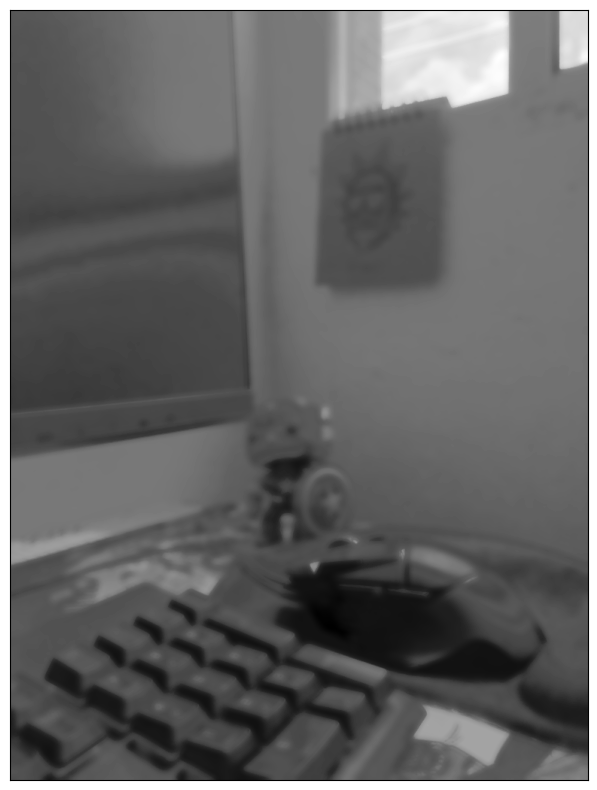

In [ ]:
final_base = (large_scale - o) * s
show_image(final_base, (10, 10))

Revertemos o log e aplicamos a transformação de Tumblin (https://dl.acm.org/doi/10.1145/311535.311544)

In [ ]:
array_divide = lambda x, y: np.divide(x, y, out=np.zeros_like(x), where=(y != 0))

In [ ]:
new_intensity = np.power(2, final_base + detail)
s_tumblin = 1.25
final_r = array_divide(r, intensity)**s_tumblin * new_intensity
final_g = array_divide(g, intensity)**s_tumblin * new_intensity
final_b = array_divide(b, intensity)**s_tumblin * new_intensity

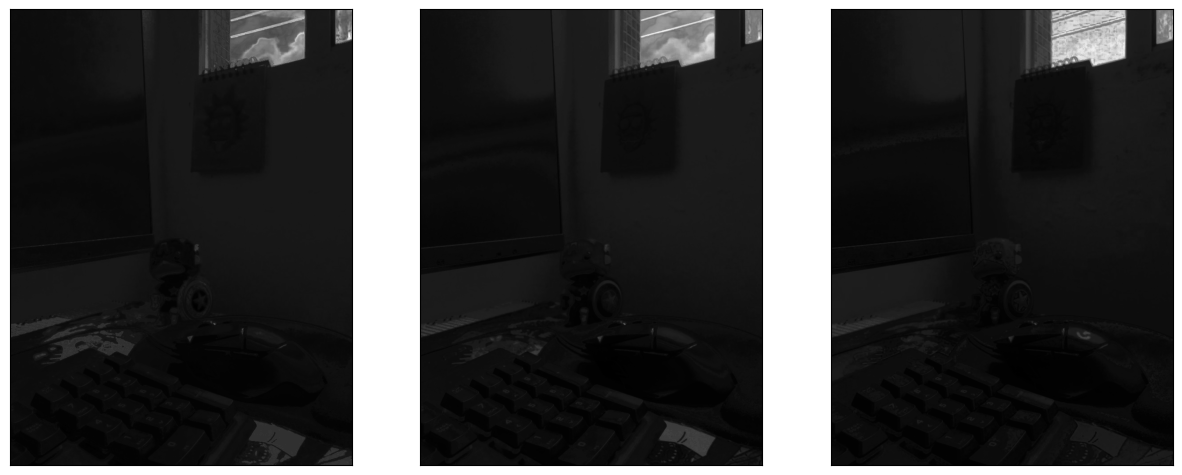

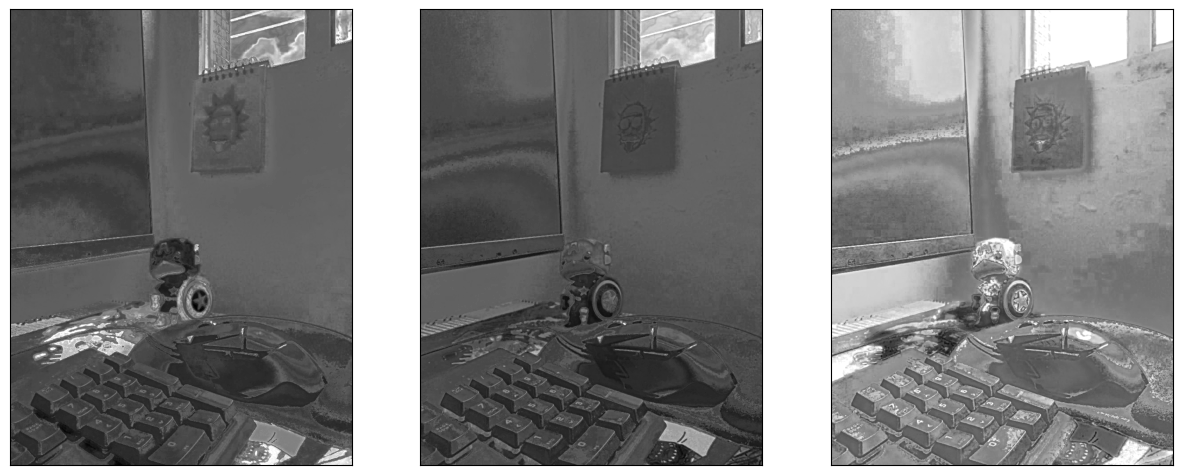

In [ ]:
new_r = np.clip(final_r, 0, 1)
new_g = np.clip(final_g, 0, 1)
new_b = np.clip(final_b, 0, 1)
channels = [new_r, new_g, new_b]
show_images([r, g, b])
show_images(channels)

Finalmente, executamos a fusão dos canais, alteração das escalas e conversão para uint8

In [ ]:
merge = np.concatenate(
    [
        new_r[..., np.newaxis],
        new_g[..., np.newaxis],
        new_b[..., np.newaxis]
    ],
    axis = -1
)
result = np.uint8(255 * merge)

Comparando

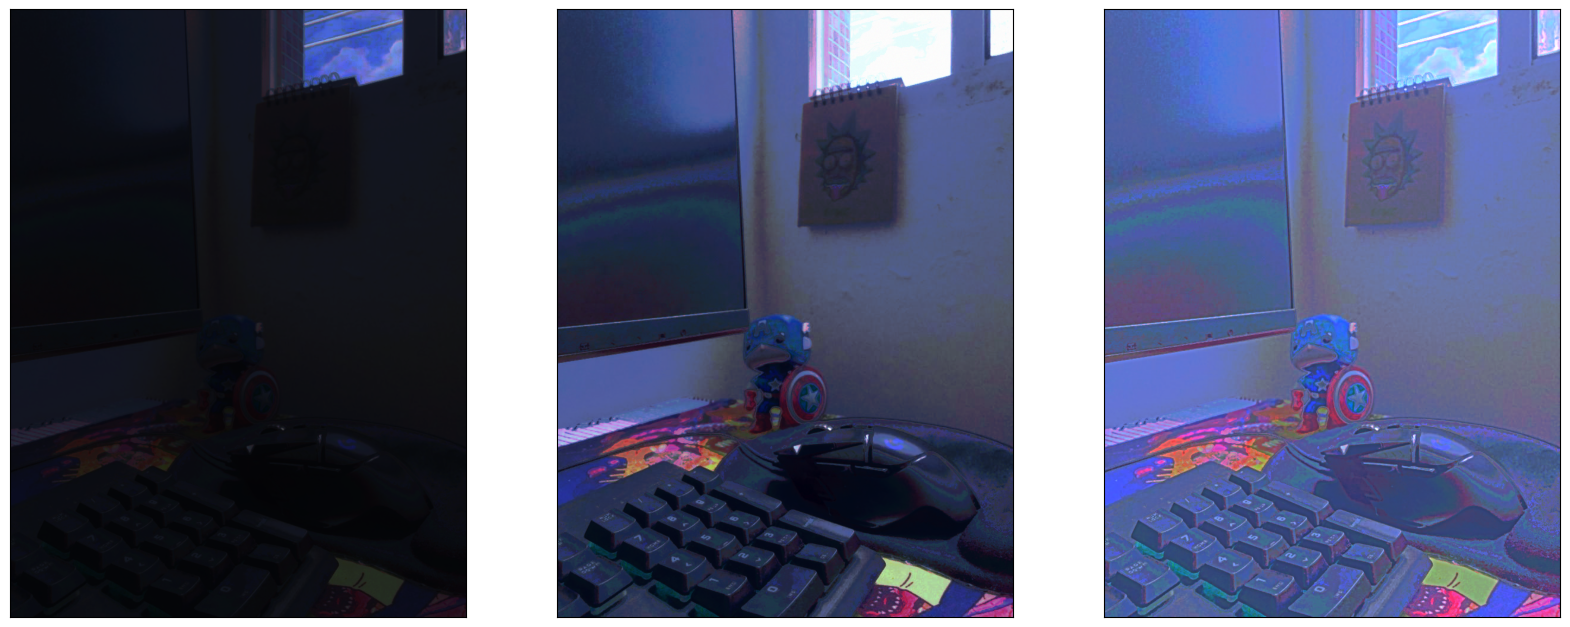

In [ ]:
show_images([hdr / hdr.max(), custom_op, result], (20, 16))

### Combinando os dois operadores

In [ ]:
interms = [
    cv2.addWeighted(custom_op, i, result.astype("float32") / 255, 1 - i, 0)
    for i in np.linspace(0.9, 0.2, 10)
]

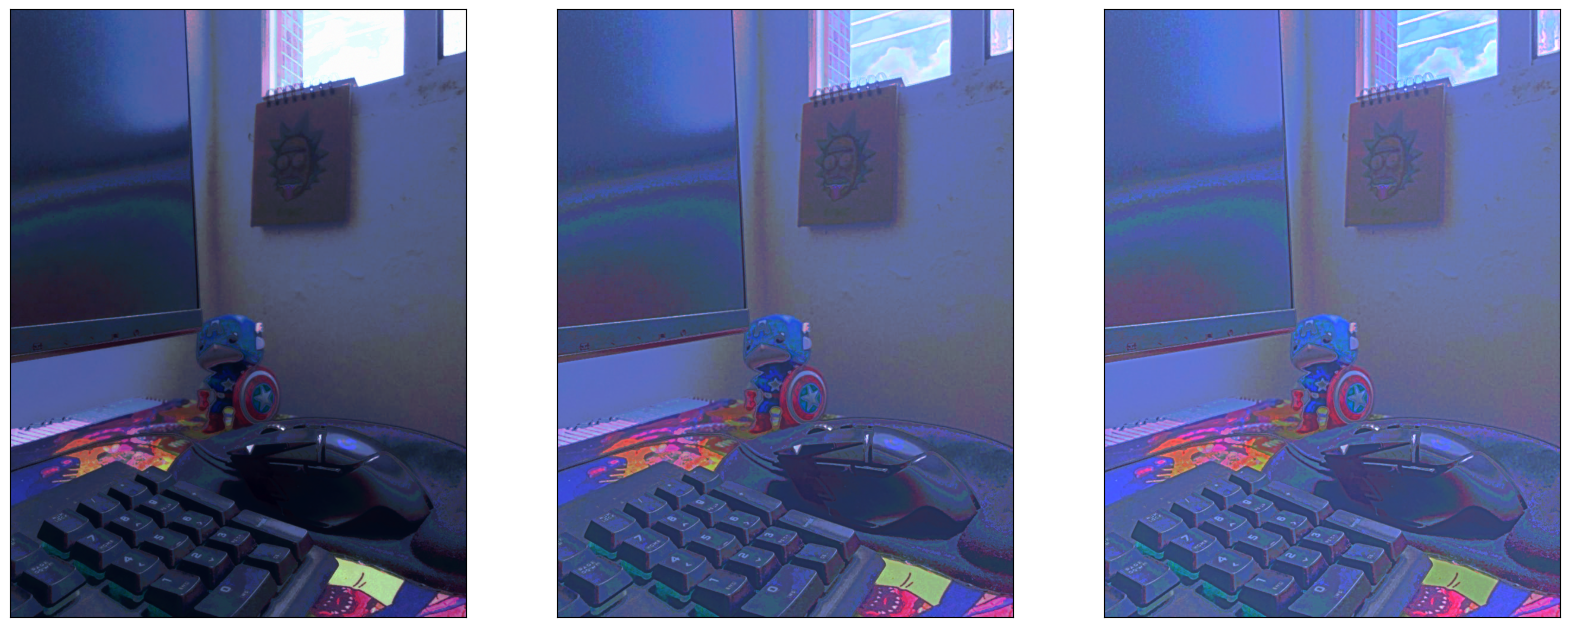

In [ ]:
show_images([custom_op, *interms, result], (20, 20))